In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import sys
sys.path.append('/fs/cbsuvlaminck2/workdir/bmg224/hiprfish/image_analysis_code')
import image_functions as imfn
from segmentation import Segmentation


In [3]:
sample_names = imfn.get_sample_names()
refl = ['gfp', 'cy5']
factors = ['method', 'plasmid', 'fov']
seg_list = []
spot_seg = [Segmentation(sample_name=sn, illumination_names=refl, fname_mod='_spot_seg')
            for sn in sample_names]
print(len(spot_seg))


62


In [4]:
import pandas as pd
spot_props_filenames = ['../data/images/' + sn + '_spot_seg_cell_id.csv' for sn in sample_names]
spot_props = [pd.read_csv(f) for f in spot_props_filenames]
print(len(spot_props))

62


In [5]:
cell_seg = [Segmentation(sample_name=sn, illumination_names=refl, fname_mod='_cell_seg')
            for sn in sample_names]
print(len(cell_seg))

62


In [6]:
cell_props_filenames = [cs.region_props_filename for cs in cell_seg]
cell_props = [pd.read_csv(f) for f in cell_props_filenames]
print(len(cell_props))

62


In [7]:
keys = [seg.get_filename_keys(factors) for seg in spot_seg]
print(len(keys))

62


In [8]:
from collections import defaultdict
def group(im_seg_list, g_index):
    im_seg_dict = defaultdict(list) 
    for im_seg in im_seg_list:
        group = im_seg[g_index[0]][g_index[1]]
        im_seg_dict[group].append(im_seg)
    return im_seg_dict


seg_list = zip(keys, spot_props, cell_props)
im_seg_dict = group(seg_list, (0,0))
for g0, s0 in im_seg_dict.items():
    im_seg_dict[g0] = group(s0, (0,1))

im_seg_dict['a'].keys()

dict_keys(['c', 'h'])

In [10]:
groups = ['a','b','c.1','e','h']
control_factor = 'c'
test_factor = 'h'

In [16]:
import numpy as np
from sklearn.metrics import auc

roc_dict = {}
for g in groups:
    roc_dict[g] = {}
    props_list_neg = im_seg_dict[g][control_factor]
    props_list_pos = im_seg_dict[g][test_factor]
    cells_true_pos = 0
    cells_false_pos = 0
    intensities = []
    for props_neg in props_list_neg:
        cells_false_pos += props_neg[1].cell_id.unique().shape[0]
        intensities += props_neg[1].Intensity.tolist()
    for props_pos in props_list_pos:
        cells_true_pos += props_pos[1].cell_id.unique().shape[0]
        intensities += props_pos[1].Intensity.tolist()

    pos_count_list = []
    neg_count_list = []
    thresholds = np.linspace(np.min(intensities), np.max(intensities), 200)
    for t in thresholds:
        cells_neg = 0
        cells_pos = 0
        for props_neg in props_list_neg:
            cells_neg += props_neg[1].loc[props_neg[1].Intensity >= t, 'cell_id'].unique().shape[0]
        for props_pos in props_list_pos:
            cells_pos += props_pos[1].loc[props_pos[1].Intensity >= t, 'cell_id'].unique().shape[0]
        neg_count_list.append(cells_neg)
        pos_count_list.append(cells_pos)

    FPR = np.array(neg_count_list)/cells_false_pos
    TPR = np.array(pos_count_list)/cells_true_pos
    print(FPR.shape, TPR.shape)
    AUC = auc(FPR, TPR)
    roc_dict[g] = (FPR, TPR, AUC)

(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)


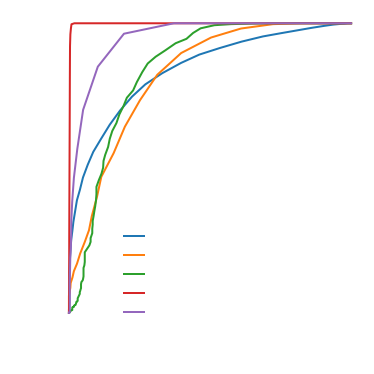

In [25]:
import matplotlib.pyplot as plt
group_labels = ['Single Probe','Ten Probes','Amplified Probes','Helper Probes','Split-HCR Probes']
dims = (5,5)
ft = 18
col = 'w'

fig, ax = plt.subplots(figsize=(dims[0], dims[1]),  tight_layout={'pad': 0})
for g, l in zip(groups, group_labels):
    fpr, tpr, AUC = roc_dict[g]
    label = l + ' AUC=' + str(np.round(AUC,3))
    ax.plot(fpr, tpr, label=label, linewidth=2)
    ax.set_xlabel('FPR', fontsize=ft, color=col)
    ax.set_ylabel('TPR', fontsize=ft, color=col)
    l = plt.legend(loc='lower right', fancybox=True, framealpha=0)
    for text in l.get_texts():
        text.set_color(col)
        text.set_fontsize(ft*4//5)
    ax.spines['top'].set_color(col)
    ax.spines['bottom'].set_color(col)
    ax.spines['left'].set_color(col)
    ax.spines['right'].set_color(col)
    ax.tick_params(direction='in', color=col, labelcolor=col, labelsize=ft*4//5) 
    output_filename = '../figures/ROC_curves.png'
    plt.savefig(output_filename, transparent=True, dpi=300)
